# Example on the impact of Resampling: Credit Card Fraud Data

We will now combine our previous discussions to investigate the effect of the resampling techniques discussed on our model performance. This time, we will use `imblearn`'s implementation of the sampling methods. We will use all default parameters for the models (no optimization yet). Again, we will use the **credit card fraud dataset**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import time
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

# metrics
from imblearn.metrics import sensitivity_score, geometric_mean_score

#resampling methods
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# pipeline
from imblearn.pipeline import Pipeline

## Prepare Data

In [2]:
df = pd.read_csv('credit_card.csv')
df.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.611712,-0.769705,-0.149759,-0.224877,2.028577,-2.019887,0.292491,-0.523020,0.358468,0.070050,...,-0.075208,0.045536,0.380739,0.023440,-2.220686,-0.201146,0.066501,0.221180,1.79,0
1,-0.814682,1.319219,1.329415,0.027273,-0.284871,-0.653985,0.321552,0.435975,-0.704298,-0.600684,...,-0.128619,-0.368565,0.090660,0.401147,-0.261034,0.080621,0.162427,0.059456,1.98,0
2,-0.318193,1.118618,0.969864,-0.127052,0.569563,-0.532484,0.706252,-0.064966,-0.463271,-0.528357,...,-0.305402,-0.774704,-0.123884,-0.495687,-0.018148,0.121679,0.249050,0.092516,0.89,0


In [3]:
# Split into trainval and holdout
X, y = df.drop('Class', axis=1), df['Class']

(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y,
                                                                  random_state=143,
                                                                  test_size=0.25,
                                                                  stratify=y)

In [4]:
models_dict = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegressor': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(random_state=143),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=143),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143)
}

## No Resampling

In [15]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
import time  # Import time for tracking runtime

# Stratified KFold and results storage
skf = StratifiedKFold(n_splits=5)
res = {}

# Start the total time tracking for all models
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    val_auc_pr_scores = []  # For storing AUC-PR values
    
    # Start time tracking for each model
    model_start = time.time()

    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

        # fit model
        model.fit(X_train, y_train)

        # predict probabilities (not class labels)
        val_probs = model.predict_proba(X_val)[:, 1]

        # Calculate precision-recall curve and AUC-PR
        precision, recall, _ = precision_recall_curve(y_val, val_probs)
        auc_pr = auc(recall, precision)
        val_auc_pr_scores.append(auc_pr)

    # End time tracking for each model
    model_end = time.time()
    model_elapsed = model_end - model_start

    # Store results for the current model
    res[model_name] = {
        'ave_val_auc_pr': np.mean(val_auc_pr_scores),  # AUC-PR
        'run_time': model_elapsed  # Time taken for this model
    }

# End the total time tracking for all models
total_end = time.time()
total_elapsed = total_end - total_start
print(f"Total Run Time for all models: {total_elapsed:.2f} seconds")

# Convert to DataFrame and display
no_sampling_df = pd.DataFrame(res).T
display(no_sampling_df)

100%|██████████| 5/5 [02:33<00:00, 30.73s/it]

Total Run Time for all models: 153.64 seconds


,ave_val_auc_pr,run_time
KNeighborsClassifier,0.618657,1.182952
LogisticRegressor,0.670646,5.876858
RandomForestClassifier,0.850307,27.147600
DecisionTreeClassifier,0.721733,2.635089
GradientBoostingClassifier,0.543836,116.787299


## With Resampling
### Random Undersampling

In [8]:
from sklearn.metrics import precision_recall_curve, auc
import time  # Importing time for tracking runtime

# Stratified KFold and results storage
skf = StratifiedKFold(n_splits=5)
undersampler = {}

# Start the total time tracking for all models
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    val_auc_pr_scores = []  # For storing AUC-PR values
    
    # Start time tracking for each model
    model_start = time.time()

    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

        # Create a pipeline with undersampling and model
        pipeline = Pipeline([('RandomUnderSampler', RandomUnderSampler(random_state=143)),
                             (model_name, model)])
        pipeline.fit(X_train, y_train)

        # predict probabilities (not class labels)
        val_probs = pipeline.predict_proba(X_val)[:, 1]

        # Calculate precision-recall curve and AUC-PR
        precision, recall, _ = precision_recall_curve(y_val, val_probs)
        auc_pr = auc(recall, precision)
        val_auc_pr_scores.append(auc_pr)

    # End time tracking for each model
    model_end = time.time()
    model_elapsed = model_end - model_start

    # Store results for the current model
    undersampler[model_name] = {
        'ave_val_auc_pr': np.mean(val_auc_pr_scores),  # AUC-PR
        'run_time': model_elapsed  # Time taken for this model
    }

# End the total time tracking for all models
total_end = time.time()
total_elapsed = total_end - total_start
print(f"Total Run Time for all models: {total_elapsed:.2f} seconds")

# Convert to DataFrame and display
undersampler_df = pd.DataFrame(undersampler).T
display(undersampler_df)

100%|██████████| 5/5 [00:02<00:00,  1.78it/s]

Total Run Time for all models: 2.81 seconds


,ave_val_auc_pr,run_time
KNeighborsClassifier,0.335310,0.103938
LogisticRegressor,0.169336,0.914570
RandomForestClassifier,0.730354,0.948955
DecisionTreeClassifier,0.440078,0.073562
GradientBoostingClassifier,0.130273,0.760698


### Random Oversampling

In [9]:
from sklearn.metrics import precision_recall_curve, auc
import time
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Stratified KFold and results storage
skf = StratifiedKFold(n_splits=5)

oversampler = {}

# log start time for total run
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    val_auc_pr_scores = []  # For storing AUC-PR values
    
    # Start time tracking for the current model
    model_start = time.time()

    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

        start_time = time.time()  # Start timing the fit and evaluation

        # Create a pipeline with Random OverSampling and model
        pipeline = Pipeline([('RandomOverSampler', RandomOverSampler(random_state=143)),
                             (model_name, model)])
        pipeline.fit(X_train, y_train)

        # Predict probabilities (not class labels) for AUC-PR
        val_probs = pipeline.predict_proba(X_val)[:, 1]

        # Calculate precision-recall curve and AUC-PR
        precision, recall, _ = precision_recall_curve(y_val, val_probs)
        auc_pr = auc(recall, precision)

        end_time = time.time()  # End timing the fit and evaluation

        val_auc_pr_scores.append(auc_pr)

    # End time tracking for the current model
    model_end = time.time()
    model_elapsed = model_end - model_start

    # Store results for the current model
    oversampler[model_name] = {
        'ave_val_auc_pr': np.mean(val_auc_pr_scores),  # Average AUC-PR across splits
        'run_time': model_elapsed  # Total run time for this model
    }

# log end time for total run
total_end = time.time()
total_elapsed = total_end - total_start
print(f"Total Run Time for all models: {total_elapsed:.2f} seconds")

# Convert to DataFrame and display
oversampler_df = pd.DataFrame(oversampler).T
display(oversampler_df)

100%|██████████| 5/5 [02:47<00:00, 33.48s/it]

Total Run Time for all models: 167.42 seconds


,ave_val_auc_pr,run_time
KNeighborsClassifier,0.545005,2.316833
LogisticRegressor,0.680234,12.233689
RandomForestClassifier,0.833094,20.364742
DecisionTreeClassifier,0.612178,1.731496
GradientBoostingClassifier,0.746200,130.760761


### SMOTE

In [10]:
from sklearn.metrics import precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import time

# Stratified KFold and results storage
skf = StratifiedKFold(n_splits=5)

smote = {}

# log start time for total run
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    val_auc_pr_scores = []  # For storing AUC-PR values

    # Start time tracking for the current model
    model_start = time.time()

    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

        # Start timing for the model training and prediction
        start_time = time.time()

        # Create a pipeline with SMOTE and the model
        pipeline = Pipeline([('SMOTEr', SMOTE(random_state=143)),
                             (model_name, model)])
        pipeline.fit(X_train, y_train)

        # Predict probabilities (not class labels) for AUC-PR calculation
        val_probs = pipeline.predict_proba(X_val)[:, 1]

        # Calculate precision-recall curve and AUC-PR
        precision, recall, _ = precision_recall_curve(y_val, val_probs)
        auc_pr = auc(recall, precision)

        # End timing for the model training and prediction
        end_time = time.time()

        # Append the AUC-PR score for this fold
        val_auc_pr_scores.append(auc_pr)

    # End time tracking for the current model
    model_end = time.time()
    model_elapsed = model_end - model_start

    # Store results for the current model
    smote[model_name] = {
        'ave_val_auc_pr': np.mean(val_auc_pr_scores),  # Average AUC-PR across splits
        'run_time': model_elapsed  # Total run time for this model
    }

# log end time for total run
total_end = time.time()
total_elapsed = total_end - total_start
print(f"Total Run Time for all models: {total_elapsed:.2f} seconds")

# Convert to DataFrame and display
smote_df = pd.DataFrame(smote).T
display(smote_df)

100%|██████████| 5/5 [05:30<00:00, 66.08s/it] 

Total Run Time for all models: 330.41 seconds


,ave_val_auc_pr,run_time
KNeighborsClassifier,0.569363,2.434796
LogisticRegressor,0.705843,9.993169
RandomForestClassifier,0.812747,73.350035
DecisionTreeClassifier,0.511439,9.337999
GradientBoostingClassifier,0.736833,235.282984


### ADASYN

In [11]:
from sklearn.metrics import precision_recall_curve, auc
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
import time

# Stratified KFold and results storage
skf = StratifiedKFold(n_splits=5)

adasyn = {}

# log start time for total run
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    val_auc_pr_scores = []  # For storing AUC-PR values

    # Start time tracking for the current model
    model_start = time.time()

    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

        # Start timing for the model training and prediction
        start_time = time.time()

        # Create a pipeline with ADASYN and the model
        pipeline = Pipeline([('ADASYN', ADASYN(random_state=143)),
                             (model_name, model)])
        pipeline.fit(X_train, y_train)

        # Predict probabilities (not class labels) for AUC-PR calculation
        val_probs = pipeline.predict_proba(X_val)[:, 1]

        # Calculate precision-recall curve and AUC-PR
        precision, recall, _ = precision_recall_curve(y_val, val_probs)
        auc_pr = auc(recall, precision)

        # End timing for the model training and prediction
        end_time = time.time()

        # Append the AUC-PR score for this fold
        val_auc_pr_scores.append(auc_pr)

    # End time tracking for the current model
    model_end = time.time()
    model_elapsed = model_end - model_start

    # Store results for the current model
    adasyn[model_name] = {
        'ave_val_auc_pr': np.mean(val_auc_pr_scores),  # Average AUC-PR across splits
        'run_time': model_elapsed  # Total run time for this model
    }

# log end time for total run
total_end = time.time()
total_elapsed = total_end - total_start
print(f"Total Run Time for all models: {total_elapsed:.2f} seconds")

# Convert to DataFrame and display
adasyn_df = pd.DataFrame(adasyn).T
display(adasyn_df)

100%|██████████| 5/5 [05:32<00:00, 66.52s/it] 

Total Run Time for all models: 332.59 seconds


,ave_val_auc_pr,run_time
KNeighborsClassifier,0.566291,2.437455
LogisticRegressor,0.711290,9.373378
RandomForestClassifier,0.797712,76.691396
DecisionTreeClassifier,0.466785,9.159748
GradientBoostingClassifier,0.699976,234.913929


### Tomek Links

In [12]:
from sklearn.metrics import precision_recall_curve, auc
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline
import time

# Stratified KFold and results storage
skf = StratifiedKFold(n_splits=5)

tomek = {}

# log start time for total run
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    val_auc_pr_scores = []  # For storing AUC-PR values

    # Start time tracking for the current model
    model_start = time.time()

    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

        # Start timing for the model training and prediction
        start_time = time.time()

        # Create a pipeline with Tomek Links and the model
        pipeline = Pipeline([('TomekLinks', TomekLinks()),
                             (model_name, model)])
        pipeline.fit(X_train, y_train)

        # Predict probabilities (not class labels) for AUC-PR calculation
        val_probs = pipeline.predict_proba(X_val)[:, 1]

        # Calculate precision-recall curve and AUC-PR
        precision, recall, _ = precision_recall_curve(y_val, val_probs)
        auc_pr = auc(recall, precision)

        # End timing for the model training and prediction
        end_time = time.time()

        # Append the AUC-PR score for this fold
        val_auc_pr_scores.append(auc_pr)

    # End time tracking for the current model
    model_end = time.time()
    model_elapsed = model_end - model_start

    # Store results for the current model
    tomek[model_name] = {
        'ave_val_auc_pr': np.mean(val_auc_pr_scores),  # Average AUC-PR across splits
        'run_time': model_elapsed  # Total run time for this model
    }

# log end time for total run
total_end = time.time()
total_elapsed = total_end - total_start
print(f"Total Run Time for all models: {total_elapsed:.2f} seconds")

# Convert to DataFrame and display
tomek_df = pd.DataFrame(tomek).T
display(tomek_df)

100%|██████████| 5/5 [02:54<00:00, 34.83s/it]

Total Run Time for all models: 174.14 seconds


,ave_val_auc_pr,run_time
KNeighborsClassifier,0.617943,5.057076
LogisticRegressor,0.675213,11.640071
RandomForestClassifier,0.798735,31.419321
DecisionTreeClassifier,0.759756,6.814844
GradientBoostingClassifier,0.637913,119.196741


### SMOTEK: Oversample with SMOTE, then Undersample with Tomek Links

In [13]:
from sklearn.metrics import precision_recall_curve, auc
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
import time

# Stratified KFold and results storage
skf = StratifiedKFold(n_splits=5)

smotek = {}

# log start time for total run
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    val_auc_pr_scores = []  # For storing AUC-PR values

    # Start time tracking for the current model
    model_start = time.time()

    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

        # Start timing for the model training and prediction
        start_time = time.time()

        # Create a pipeline with SMOTE and Tomek Links followed by the model
        pipeline = Pipeline([('SMOTEK', SMOTETomek(random_state=143)),
                             (model_name, model)])
        pipeline.fit(X_train, y_train)

        # Predict probabilities (not class labels) for AUC-PR calculation
        val_probs = pipeline.predict_proba(X_val)[:, 1]

        # Calculate precision-recall curve and AUC-PR
        precision, recall, _ = precision_recall_curve(y_val, val_probs)
        auc_pr = auc(recall, precision)

        # End timing for the model training and prediction
        end_time = time.time()

        # Append the AUC-PR score for this fold
        val_auc_pr_scores.append(auc_pr)

    # End time tracking for the current model
    model_end = time.time()
    model_elapsed = model_end - model_start

    # Store results for the current model
    smotek[model_name] = {
        'ave_val_auc_pr': np.mean(val_auc_pr_scores),  # Average AUC-PR across splits
        'run_time': model_elapsed  # Total run time for this model
    }

# log end time for total run
total_end = time.time()
total_elapsed = total_end - total_start
print(f"Total Run Time for all models: {total_elapsed:.2f} seconds")

# Convert to DataFrame and display
smotek_df = pd.DataFrame(smotek).T
display(smotek_df)

100%|██████████| 5/5 [06:44<00:00, 80.81s/it] 

Total Run Time for all models: 404.05 seconds


,ave_val_auc_pr,run_time
KNeighborsClassifier,0.562949,17.240974
LogisticRegressor,0.711686,24.685352
RandomForestClassifier,0.803757,88.266221
DecisionTreeClassifier,0.504067,24.108864
GradientBoostingClassifier,0.765133,249.733488


## Comparison

In [19]:
# Combine all DataFrames into one, adding a column for the sampling method
oversampler_df['sampling_method'] = 'Random OverSampling'
smote_df['sampling_method'] = 'SMOTE'
tomek_df['sampling_method'] = 'Tomek Links'
adasyn_df['sampling_method'] = 'ADASYN'
smotek_df['sampling_method'] = 'SMOTEK'
no_sampling_df['sampling_method'] = 'No Sampling'

# Concatenate all DataFrames
comparison_df = pd.concat([no_sampling_df, oversampler_df, smote_df, tomek_df, adasyn_df, smotek_df])

# Reset the index so that model names are preserved
comparison_df = comparison_df.reset_index()

# Display the comparison DataFrame
display(comparison_df)

,Model,ave_val_auc_pr,run_time,sampling_method
0,KNeighborsClassifier,0.618657,1.182952,No Sampling
1,LogisticRegressor,0.670646,5.876858,No Sampling
2,RandomForestClassifier,0.850307,27.147600,No Sampling
3,DecisionTreeClassifier,0.721733,2.635089,No Sampling
4,GradientBoostingClassifier,0.543836,116.787299,No Sampling
5,KNeighborsClassifier,0.545005,2.316833,Random OverSampling
6,LogisticRegressor,0.680234,12.233689,Random OverSampling
7,RandomForestClassifier,0.833094,20.364742,Random OverSampling
8,DecisionTreeClassifier,0.612178,1.731496,Random OverSampling
9,GradientBoostingClassifier,0.746200,130.760761,Random OverSampling


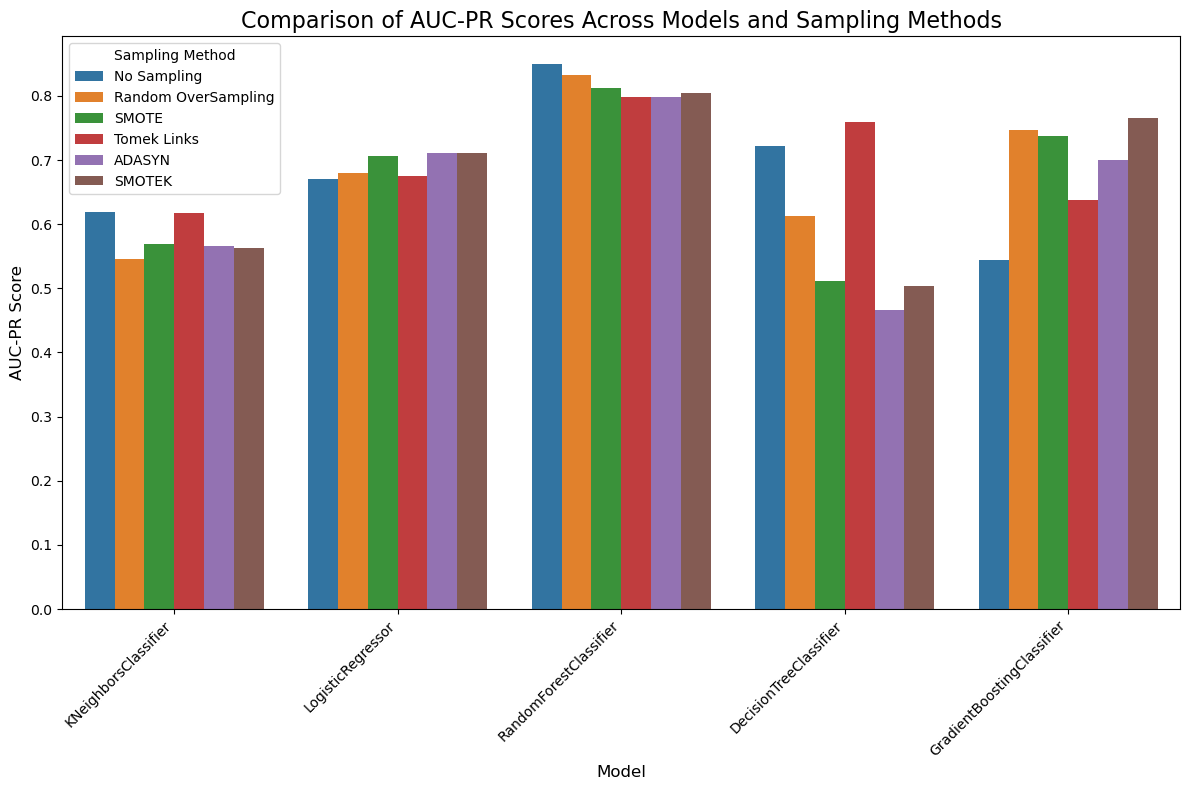

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting AUC-PR comparison across models and sampling methods
plt.figure(figsize=(12, 8))
sns.barplot(x='index', y='ave_val_auc_pr', hue='sampling_method', data=comparison_df)

plt.title('Comparison of AUC-PR Scores Across Models and Sampling Methods', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('AUC-PR Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Sampling Method')
plt.tight_layout()
plt.show()